In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Create list of all targets (minus background noise)
dataset_path = '/Users/Willie/data-speech_commands_v0.02'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['right', 'eight', 'cat', 'tree', 'backward', 'learn', 'bed', 'happy', 'go', 'dog', 'no', 'wow', 'follow', 'nine', 'left', 'stop', 'three', 'sheila', 'one', 'bird', 'zero', 'seven', 'up', 'visual', 'marvin', 'two', 'house', 'down', 'six', 'yes', 'on', 'five', 'forward', 'off', 'four']


In [3]:
# Settings
feature_sets_path = ''
feature_sets_filename = 'Part1_Demo.npz'
model_filename = 'Demo.h5'
wake_word = 'stop'

In [4]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [5]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [6]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77438, 16, 16)
(9690, 16, 16)
(9728, 16, 16)


In [7]:
# Peek at labels
print(y_val)

[11. 28.  1. ... 13. 27.  1.]


In [8]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [9]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 0.]


In [10]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.0369453044375645
0.9630546955624355


In [11]:
# View the dimensions of our input data
print(x_train.shape)

(77438, 16, 16)


In [12]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77438, 16, 16, 1)
(9690, 16, 16, 1)
(9728, 16, 16, 1)


In [13]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [14]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [16]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [17]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
775/775 [==============================] - 17s 21ms/step - loss: 0.1158 - acc: 0.9664 - val_loss: 0.1413 - val_acc: 0.9504
Epoch 2/30
775/775 [==============================] - 15s 19ms/step - loss: 0.0762 - acc: 0.9760 - val_loss: 0.0569 - val_acc: 0.9832
Epoch 3/30
775/775 [==============================] - 14s 19ms/step - loss: 0.0654 - acc: 0.9792 - val_loss: 0.0574 - val_acc: 0.9819
Epoch 4/30
775/775 [==============================] - 26s 34ms/step - loss: 0.0607 - acc: 0.9818 - val_loss: 0.0678 - val_acc: 0.9801
Epoch 5/30
775/775 [==============================] - 33s 42ms/step - loss: 0.0589 - acc: 0.9826 - val_loss: 0.0700 - val_acc: 0.9822
Epoch 6/30
775/775 [==============================] - 22s 28ms/step - loss: 0.0582 - acc: 0.9832 - val_loss: 0.0822 - val_acc: 0.9750
Epoch 7/30
775/775 [==============================] - 30s 39ms/step - loss: 0.0585 - acc: 0.9828 - val_loss: 0.0674 - val_acc: 0.9764
Epoch 8/30
775/775 [==============================] - 21s 27ms

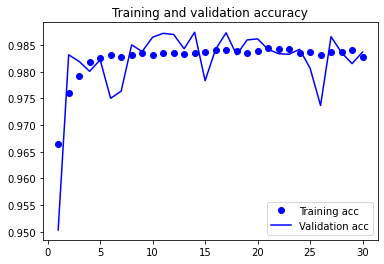

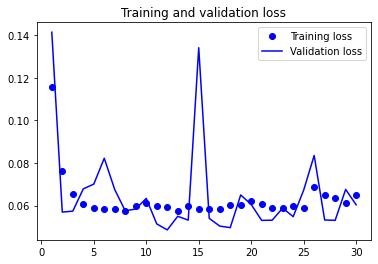

In [18]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# Save the model as a file
models.save_model(model, model_filename)

In [20]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

18
23
27
32
70
86
101
159
168
187
195
227
236
264
328
358
372
405
419
428
437
450
461
570
604
663
688
698
781
791
842
893
915
923
930
938
950
955
965
982
1012
1076
1113
1120
1155
1168
1194
1210
1218
1237
1273
1283
1287
1293
1312
1314
1320
1329
1389
1391
1447
1455
1523
1525
1594
1598
1634
1641
1678
1696
1706
1714
1742
1780
1788
1791
1803
1833
1877
1884
1927
1934
1948
2077
2081
2106
2108
2179
2189
2223
2256
2266
2303
2366
2401
2409
2478
2481
2482
2496
2497
2518
2552
2562
2587
2656
2705
2717
2719
2779
2784
2839
2876
2878
2899
2925
2938
2968
2979
2997
3016
3030
3042
3054
3057
3072
3105
3117
3129
3148
3157
3163
3185
3206
3244
3296
3301
3410
3418
3423
3460
3515
3553
3567
3589
3603
3605
3635
3644
3665
3667
3677
3684
3691
3745
3753
3770
3845
3903
3926
3929
3943
3964
3991
4026
4030
4043
4091
4122
4147
4172
4207
4249
4267
4287
4303
4315
4346
4373
4481
4482
4502
4503
4582
4675
4684
4755
4787
4792
4843
4920
4951
4965
5007
5095
5105
5111
5150
5153
5200
5209
5283
5299
5384
5388
5401
5407
5412
5466
5

In [21]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0  Prediction: [[0.01119864]]
Answer: 1.0  Prediction: [[0.37910914]]
Answer: 0.0  Prediction: [[1.234992e-09]]
Answer: 0.0  Prediction: [[4.215751e-07]]
Answer: 0.0  Prediction: [[0.00804475]]
Answer: 0.0  Prediction: [[6.384225e-08]]
Answer: 0.0  Prediction: [[0.00036463]]
Answer: 0.0  Prediction: [[2.785118e-11]]
Answer: 0.0  Prediction: [[0.00039855]]
Answer: 0.0  Prediction: [[1.992629e-06]]


In [22]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

304/304 [==============================] - 1s 3ms/step - loss: 0.0736 - acc: 0.9833


[0.07364676147699356, 0.9833470582962036]